# Test for Coriolis Force

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import seaborn
import xarray
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/alam/Desktop/Code/jax-cfd/jax_cfd/')
import jax_cfd.sb as cfd
import utils

In [2]:
size = 256
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 1000
outer_steps = 500

max_velocity = 7.0
cfl_safety_factor = 0.005

angular_velocity = 10

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct an initial velocity field with constant x velocity
x_velocity_fn = lambda x, y: jnp.ones_like(x)
y_velocity_fn = lambda x, y: jnp.zeros_like(x)
v0 = cfd.initial_conditions.initial_velocity_field((x_velocity_fn, y_velocity_fn), grid)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Add in forcing
forcing = cfd.forcings.rotational_turbulence_forcing(grid, 
                                                 constant_magnitude=1.0,
                                                 constant_wavenumber=4.0,
                                                 linear_coefficient=-0.1,
                                                 angular_velocity=angular_velocity,
                                                 dt=dt)

# In case for a change in viscosity term
diffuse = cfd.diffusion.diffuse

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid,
        diffuse=diffuse, forcing=forcing),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
_, trajectory = jax.device_get(rollout_fn(v0))

In [3]:
# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')

Component 0: GridVariable(array=GridArray(data=array([[[0.93921816, ..., 0.93921816],
        ...,
        [0.93921816, ..., 0.93921816]],

       ...,

       [[0.84102   , ..., 0.84102   ],
        ...,
        [0.84102   , ..., 0.84102   ]]],
      shape=(500, 256, 256), dtype=float32), offset=(1.0, 0.5), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[-0.34350538, ..., -0.34350538],
        ...,
        [-0.34350538, ..., -0.34350538]],

       ...,

       [[ 0.59673923, ...,  0.59673923],
        ...,
        [ 0.59673923, ...,  0.59673923]]],
      shape=(500, 256, 256), dtype=float32), offset=(0.5, 1.0), grid=Grid(shape=(256, 256), step=(0.02454369260617026, 0.02454369260617026), domain=((0.0, 6.283185307

In [4]:
v = np.transpose(np.array([trajectory[0].data,trajectory[1].data]),(1,0,2,3))

In [5]:
vx = np.mean(v[:,0], axis=(1,2))
vy = np.mean(v[:,1], axis=(1,2))

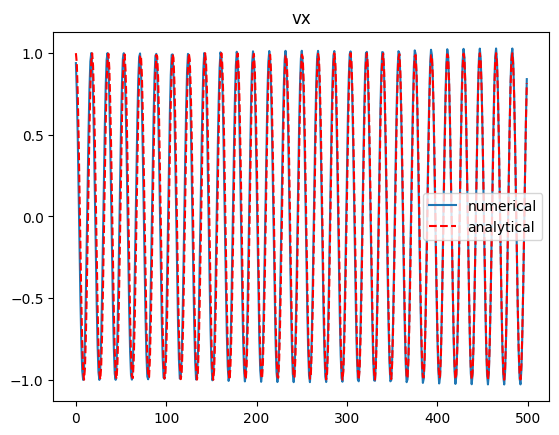

In [6]:
plt.plot(vx,label='numerical')
time = np.linspace(0, outer_steps*inner_steps*dt, outer_steps)
analytical_vx = np.cos(2*angular_velocity*time)
plt.plot(analytical_vx, 'r--',label='analytical')
plt.title('vx')
plt.legend()

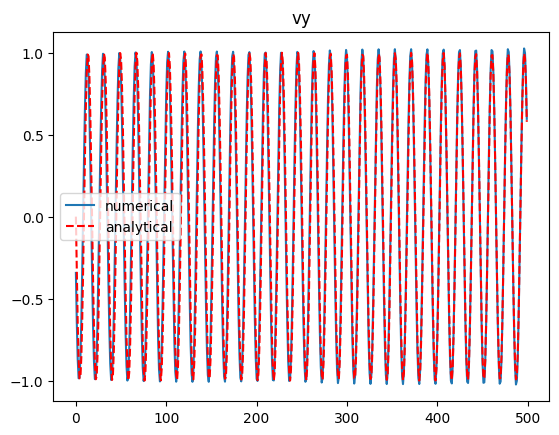

In [7]:
plt.plot(vy,label='numerical')
time = np.linspace(0, outer_steps*inner_steps*dt, outer_steps)
analytical_vy = -np.sin(2*angular_velocity*time)
plt.plot(analytical_vy, 'r--',label='analytical')
plt.title('vy')
plt.legend()

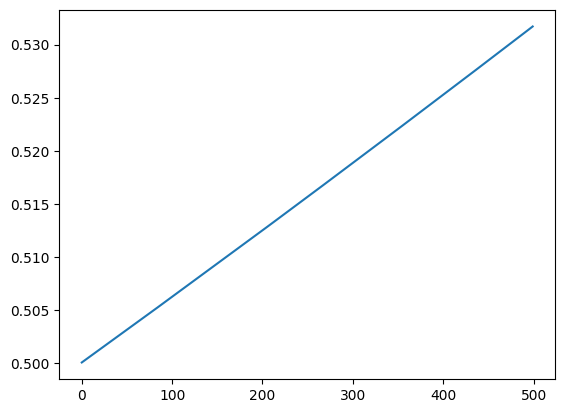

In [8]:
energy = utils.compute_average_ke_over_time(v)
plt.plot(energy)